# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm, notebook_tqdm

from torchtext import data
import re
# custom path
os.chdir('..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data prep

In [2]:
THESTACK = "./data/raw/thestack_v2/"

MAXCHARS = 2000
MAXBLOCKS = 15

### Load channels

In [3]:
files = Path(THESTACK).rglob("*.txt")

thestack = []
for f in files:
    content = f.read_text()
    n_blocks, _ = divmod(len(content), MAXCHARS)
    for i in range(min(n_blocks, MAXBLOCKS)):
        block = content[i*MAXCHARS: (i+1)*MAXCHARS]
        thestack.append((block, f.parent.name))
    
thestack = pd.DataFrame(thestack, columns=["content", "lang"])

In [4]:
thestack.sample(5)

,content,lang
1977,= score;\n }\n }\n }\n Syste...,TGLANG_LANGUAGE_JAVA
2945,%%--------------------------------------------...,TGLANG_LANGUAGE_ERLANG
1591,"r):\n """"""\n Record last window_size * wi...",TGLANG_LANGUAGE_PYTHON
864,#region Office365RelayDependencies\n<#\nOffice...,TGLANG_LANGUAGE_POWERSHELL
5535,"}\n\n#### look for ""..,D""\n else if (mat...",TGLANG_LANGUAGE_AWK


In [5]:
thestack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5997 entries, 0 to 5996
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  5997 non-null   object
 1   lang     5997 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


### EDA

In [6]:
from src.train.plot_utils import barplots

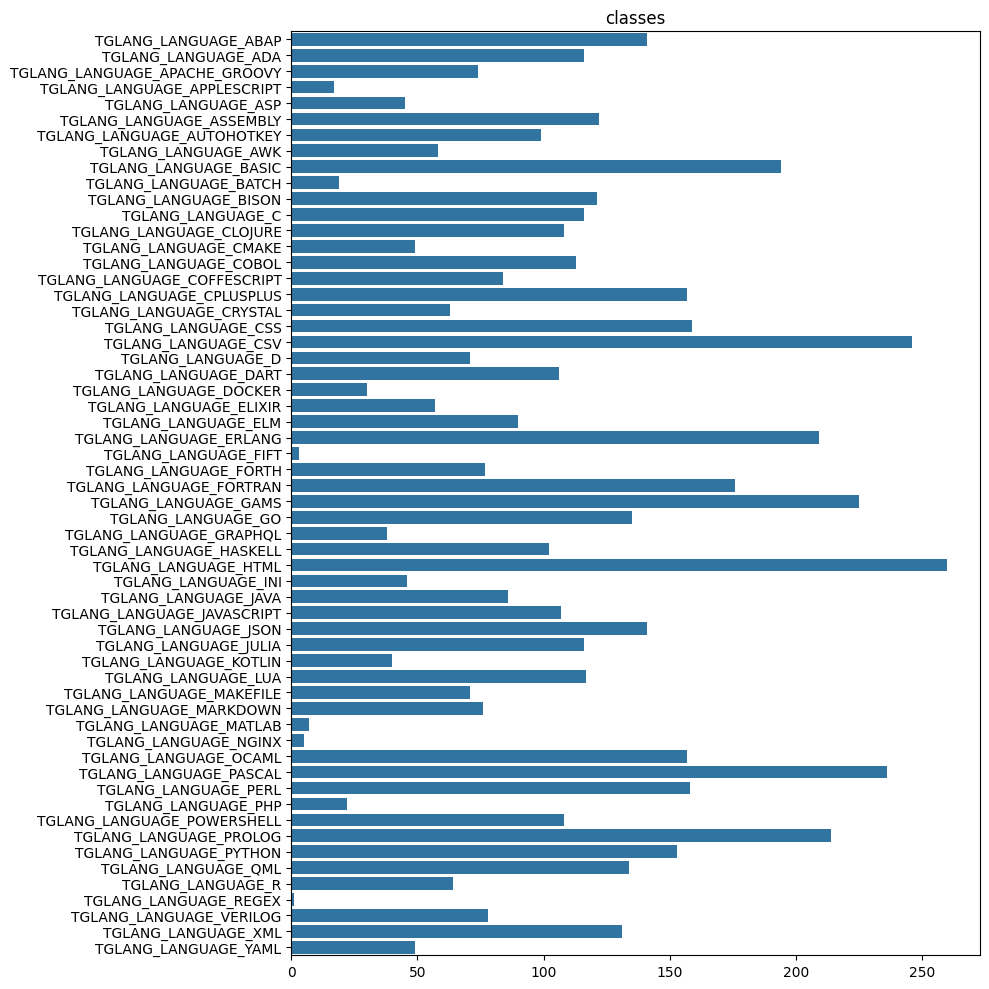

In [7]:
barplots({
    'classes': thestack['lang']
}, 1, 1, horizontal=True, fig_dims=(10, 10))

### Load stopwords

In [8]:
# stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

# stopwords = sum(stopwords, [])

stopwords = [
    "yy",
    "you",
    "yes",
    "year",
    "year_all",
    "x86",
    "x3",
    "x2",
    "word",
    "written",
    "work",
    "x1",
    "hello",
    "world",
        "µg",
    "zone",
    "zero",
    "za",
    "your",
    "www",
    "writing",
    "would",
    "without",
    "windows",
    "will",
    "프록시",
    "애플리케이션",
    "대한",
    "表示视频片段",
    "表示",
    "结尾",
    "支持",
    "当字符串以",
    "单位为像素",
    "为100像素",
]

len(stopwords)

35

#### Extract non-words chars

In [9]:
import re

In [10]:
extract_punct = lambda x: " ".join(re.findall("[^\w\s\.\"']", x))

In [11]:
thestack["punct"] = thestack["content"].apply(extract_punct)

In [12]:
thestack.sample(4)

,content,lang,punct
4380,evices.Interfaces).NotTo(BeEmpty())\n\n\t\t\t\...,TGLANG_LANGUAGE_GO,") ( ( ) ) ( ) , : = ( ) ( ) ( ) ( ( ) , ) / / ..."
2838,%% @author Marc Worrell <marc@worrell.nl>\n%% ...,TGLANG_LANGUAGE_ERLANG,"% % @ < @ > % % @ % % @ % % % % % % , ( ) ; % ..."
5172,b\n @test d.d !== df.d\n @test df == df2...,TGLANG_LANGUAGE_JULIA,"@ ! = = @ = = = ( , ( [ , , ] ) ) @ ! = = @ ! ..."
5179,"c == select(df, :x4, :x2, :x3, :x1)\n\n @te...",TGLANG_LANGUAGE_JULIA,"= = ( , : , : , : , : ) @ ( , ( [ : , : ] ) , ..."


## Experiments

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

# from xgboost import XGBClassifier

import itertools

In [14]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, input_fields, preprocessing, vect, est):
        self.INPUT_FIELDS = input_fields
        self.vect = VECTORIZERS[vect]
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        assert preprocessing in ['raw']
        self.preprocessing = preprocessing
        
    def prepare_data(self, is_final):
        # combine fields
        data = thestack.copy()
        data["text"] = thestack.apply(lambda x: " ".join([x[f] for f in self.INPUT_FIELDS]),
                                      axis=1)
        # split into  train and test
        one, self.test_inputs = train_test_split(data, test_size=0.2, random_state=24, shuffle=True,)
        comb_datasets = [one, self.test_inputs] if is_final else [one]
        self.train_inputs = pd.concat(comb_datasets, axis=0)
        # x and y
        self.y_train = self.train_inputs['lang']
        self.y_test = self.test_inputs['lang']
        self.X_train = self.vect.fit_transform(self.train_inputs['text'])
        self.X_test = self.vect.transform(self.test_inputs['text'])
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        # fit and eval
        self.clf.fit(self.X_train, self.y_train)
        self.predictions = pd.DataFrame({
                    'true': trainer.test_inputs['lang'],
                    'predicted': trainer.clf.predict(trainer.X_test)
                })
        score = self.predictions.apply(lambda x: x['predicted'] in x['true'], axis=1).mean()
        return score

### Set hyper-parameters

In [15]:
INPUTS = [
    'content',
#     "punct",
]

PREPROCESSING = [
    'raw',
]

vect_params = dict(
    max_df=0.25, 
    min_df=5,
    max_features=5000,
    binary=False, 
    ngram_range=(1,1), 
    stop_words=stopwords,
    tokenizer= lambda x: x.split(),
#     tokenizer=lambda x: re.split("\W+", x),
    
)
VECTORIZERS = {
    'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
    cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [16]:
input_combinations = [INPUTS] #list(itertools.combinations(INPUTS, r=2)) + [INPUTS]

train_params = list(itertools.product( 
                                input_combinations,
                                      PREPROCESSING,
                                VECTORIZERS.keys(), 
                                ESTIMATORS.keys()))

len(train_params)

4

### Run experiments

In [17]:
results = []

for params in notebook_tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['input_fields', 'preprocessing','vect', 'est', 'score'])

# experiments:   0%|                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  25%|████████████████████████████████████████▊                                                                                                                          | 1/4 [00:00<00:01,  1.72it/s]/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
# experiments:  50%|█████████████████████████████████████████████████████████████████████████████████▌            

In [18]:
print(results.sort_values('score', ascending=False).to_markdown())

|    | input_fields   | preprocessing   | vect   | est   |    score |
|---:|:---------------|:----------------|:-------|:------|---------:|
|  3 | ['content']    | raw             | bow    | mnb   | 0.855833 |
|  0 | ['content']    | raw             | tfidf  | cnb   | 0.843333 |
|  2 | ['content']    | raw             | bow    | cnb   | 0.825833 |
|  1 | ['content']    | raw             | tfidf  | mnb   | 0.770833 |


### Review errors

In [19]:
from sklearn.metrics import top_k_accuracy_score

#### Train

In [20]:
best_params = results.sort_values("score", ascending=False).iloc[0].to_dict()
best_params.pop("score")

0.8558333333333333

In [21]:
trainer = Trainer(**best_params)
s = trainer.run_eval(final=False)
print(s)

/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.8558333333333333


#### Classification report

In [22]:
from sklearn.metrics import classification_report

In [23]:
test_pred = trainer.clf.predict(trainer.X_test)

is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs[is_wrong]

errors['predicted'] = test_pred[is_wrong]

/var/folders/fg/vxz9bx5n1vvb2p8k4cr_wc9h0000gp/T/ipykernel_82168/1370959209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors['predicted'] = test_pred[is_wrong]


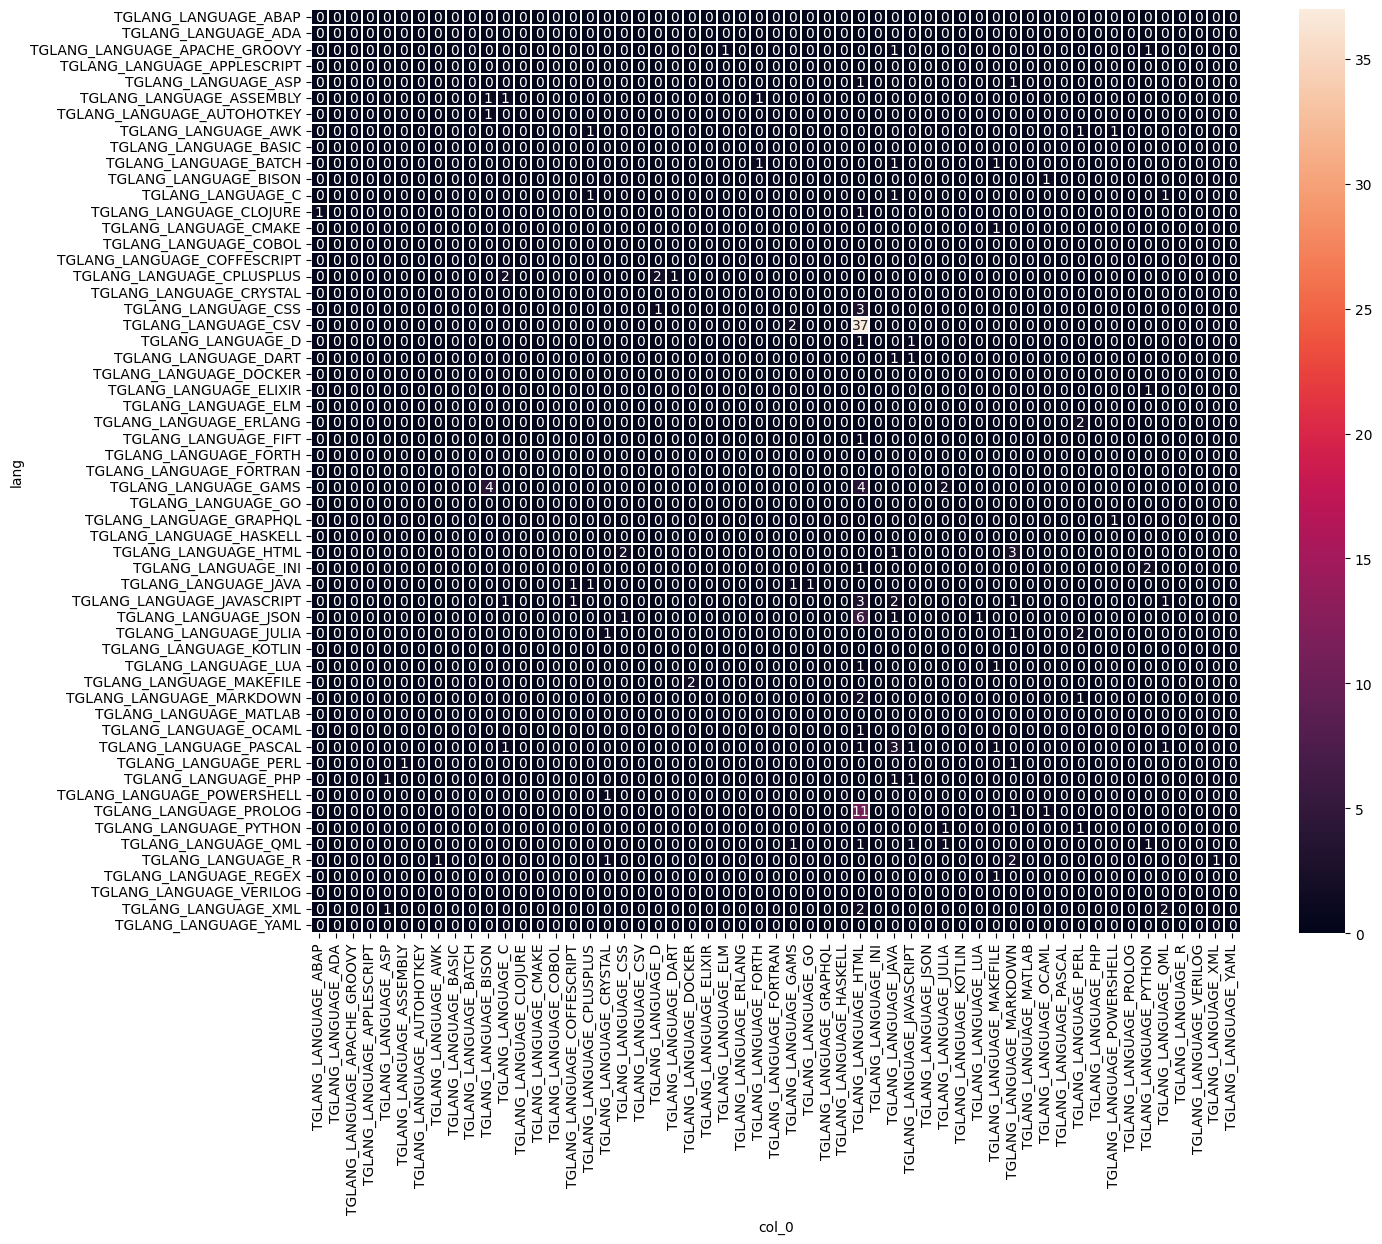

In [24]:
ct = pd.crosstab(trainer.y_test, test_pred)
for i,k in ct.iterrows():
    k[i] = 0


plt.figure(figsize=(15,12))
sns.heatmap(ct, annot=True, linewidths=0.01);

In [25]:
metrics = pd.DataFrame(classification_report(trainer.y_test, test_pred, output_dict=True, zero_division=0)).T

metrics = metrics.query("support > 0").sort_values('f1-score', ascending=True)

print(metrics.to_markdown())

|                               |   precision |   recall |   f1-score |   support |
|:------------------------------|------------:|---------:|-----------:|----------:|
| TGLANG_LANGUAGE_FIFT          |    0        | 0        |   0        |    1      |
| TGLANG_LANGUAGE_REGEX         |    0        | 0        |   0        |    1      |
| TGLANG_LANGUAGE_BATCH         |    1        | 0.25     |   0.4      |    4      |
| TGLANG_LANGUAGE_CSV           |    1        | 0.290909 |   0.450704 |   55      |
| TGLANG_LANGUAGE_HTML          |    0.393701 | 0.892857 |   0.546448 |   56      |
| TGLANG_LANGUAGE_JAVASCRIPT    |    0.705882 | 0.571429 |   0.631579 |   21      |
| TGLANG_LANGUAGE_PHP           |    1        | 0.5      |   0.666667 |    6      |
| TGLANG_LANGUAGE_MARKDOWN      |    0.6      | 0.833333 |   0.697674 |   18      |
| TGLANG_LANGUAGE_JAVA          |    0.612903 | 0.826087 |   0.703704 |   23      |
| TGLANG_LANGUAGE_MAKEFILE      |    0.666667 | 0.833333 |   0.740741 |   12

#### Errors

In [26]:
TRUE_CLASS = "TGLANG_LANGUAGE_CSV"
PRED_CLASS = "TGLANG_LANGUAGE_HTML"

class_errors = trainer.test_inputs[(trainer.y_test == TRUE_CLASS) & (test_pred == PRED_CLASS)]

print(class_errors["content"].sample(4).tolist(), sep="\n"*3, )

['Datum,NieuwOpgenomenVerdacht\n2020-02-27,0\n2020-02-28,1\n2020-02-29,0\n2020-03-01,0\n2020-03-02,0\n2020-03-03,0\n2020-03-04,0\n2020-03-05,1\n2020-03-06,0\n2020-03-07,0\n2020-03-08,0\n2020-03-09,2\n2020-03-10,1\n2020-03-11,0\n2020-03-12,0\n2020-03-13,0\n2020-03-14,0\n2020-03-15,1\n2020-03-16,0\n2020-03-17,0\n2020-03-18,0\n2020-03-19,2\n2020-03-20,1\n2020-03-21,3\n2020-03-22,1\n2020-03-23,3\n2020-03-24,1\n2020-03-25,2\n2020-03-26,4\n2020-03-27,1\n2020-03-28,2\n2020-03-29,2\n2020-03-30,2\n2020-03-31,1\n2020-04-01,2\n2020-04-02,3\n2020-04-03,0\n2020-04-04,3\n2020-04-05,3\n2020-04-06,1\n2020-04-07,2\n2020-04-08,0\n2020-04-09,1\n2020-04-10,1\n2020-04-11,2\n2020-04-12,1\n2020-04-13,1\n2020-04-14,2\n2020-04-15,1\n2020-04-16,2\n2020-04-17,1\n2020-04-18,0\n2020-04-19,1\n2020-04-20,1\n2020-04-21,0\n2020-04-22,0\n2020-04-23,0\n2020-04-24,1\n2020-04-25,0\n2020-04-26,0\n2020-04-27,0\n2020-04-28,1\n2020-04-29,0\n2020-04-30,2\n2020-05-01,0\n2020-05-02,2\n2020-05-03,0\n2020-05-04,2\n2020-05-05,0\n20

#### vectorizer

In [27]:
from collections import Counter

In [28]:
vocab = trainer.vect.vocabulary_

In [29]:
for x,_ in Counter(vocab).most_common(25):
    print(f'"{x}",')

"—",
"è",
"~p~n",",
"~p",",
"~p"",
"~p",
"~f:(fun",
"~docs",
"~doc:",
"~=",
"~",
"}}",
"}\n\n",
"};",
"},",
"});",
"}).",
"}),",
"}))",
"})",
"}"",
"||",
"|>",
"|",
"{};",


In [30]:
Counter(vocab).most_common(100)

[('—', 4999),
 ('è', 4998),
 ('~p~n",', 4997),
 ('~p",', 4996),
 ('~p"', 4995),
 ('~p', 4994),
 ('~f:(fun', 4993),
 ('~docs', 4992),
 ('~doc:', 4991),
 ('~=', 4990),
 ('~', 4989),
 ('}}', 4988),
 ('}\\n\\n', 4987),
 ('};', 4986),
 ('},', 4985),
 ('});', 4984),
 ('}).', 4983),
 ('}),', 4982),
 ('}))', 4981),
 ('})', 4980),
 ('}"', 4979),
 ('||', 4978),
 ('|>', 4977),
 ('|', 4976),
 ('{};', 4975),
 ('{},', 4974),
 ('{})', 4973),
 ('{}', 4972),
 ('{{', 4971),
 ('{string}', 4970),
 ('{stop,', 4969),
 ('{skip,', 4968),
 ('{organization_id,', 4967),
 ('{ok,', 4966),
 ('{noreply,', 4965),
 ('{error,', 4964),
 ('{\\n}\\n","variant":"id:', 4963),
 ('{\\n', 4962),
 ('{@link', 4961),
 ('{:type', 4960),
 ('{:query', 4959),
 ('{:ok,', 4958),
 ('{:noreply,', 4957),
 ('{:error,', 4956),
 ('{:added', 4955),
 ('{-|', 4954),
 ('{-#', 4953),
 ('{-', 4952),
 ('{**', 4951),
 ("{'src':", 4950),
 ("{'congruent':", 4949),
 ('{%', 4948),
 ('{$R', 4947),
 ('{$IFDEF', 4946),
 ('{$ENDIF}', 4945),
 ('{$$', 4944),


#### Fixes

**fixes**
- [ ] update stopwords
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [ ] sample weights for secondary
- [ ] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [31]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [32]:
TARGET_LABELS = Path("./src/tglang/langs_enum.txt").read_text().split("\n")

In [228]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.clf_labels = clf.classes_.tolist()
        self.target_labels = TARGET_LABELS
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgLang(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf):
        super().__init__()
        self.vect = vect
        self.clf = clf
        
        
    def select_top_class(self, probs: torch.Tensor) -> int:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb' and probs.std(0) < 0.0001:
            return 0
        elif self.clf.nb == 'mnb' and probs.max() < 0.1:
            return 0
        max_index = torch.argmax(probs, 0)
        class_label = self.clf.clf_labels[max_index.item()]
        return self.clf.target_labels.index(class_label)
        
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[int]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_class(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

In [229]:
tokenize_text = lambda x: x.split()

In [230]:

trainer = Trainer(**best_params)
_ = trainer.run_eval(final=False)

tglang = TgLang(
    TextVectorizer(best_params["vect"], trainer.vect),
    NaiveBayes(best_params["est"], trainer.clf),
)

/Users/rustem.galiullin/opt/miniconda3/envs/tgwebapp/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [257]:

batch = trainer.test_inputs.sample(5)
inputs = batch["content"].apply(tokenize_text).tolist()
gt = batch["lang"].tolist()

predictions = tglang(inputs)

In [258]:
for inp, out, index in zip(inputs, gt, predictions):
    print(f"Predicted {TARGET_LABELS[index]!r}. "
          f"True: {out!r}", 
          end="\n\n")
    print(inp[-100:])
    print("="*50, end="\n\n")

Predicted 'TGLANG_LANGUAGE_JSON'. True: 'TGLANG_LANGUAGE_JSON'

['\\"PS', 'MarkSweep\\"\\n', 'gc_collections:', '0\\n', 'gc_time:', '0\\n}\\n"}},{"pid":0,"ph":"i","name":"Memory', 'sample","ts":1523984639754000,"args":{"JVM', 'stats":"heap_memory_usage:', '355152480\\nnon_heap_memory_usage:', '110533480\\nloaded_class_count:', '13359\\nthread_count:', '35\\ngarbage_collection_stats', '{\\n', 'name:', '\\"PS', 'Scavenge\\"\\n', 'gc_collections:', '0\\n', 'gc_time:', '0\\n}\\ngarbage_collection_stats', '{\\n', 'name:', '\\"PS', 'MarkSweep\\"\\n', 'gc_collections:', '0\\n', 'gc_time:', '0\\n}\\n"}},{"pid":0,"ph":"i","name":"Memory', 'sample","ts":1523984639757000,"args":{"JVM', 'stats":"heap_memory_usage:', '355152480\\nnon_heap_memory_usage:', '110540224\\nloaded_class_count:', '13359\\nthread_count:', '35\\ngarbage_collection_stats', '{\\n', 'name:', '\\"PS', 'Scavenge\\"\\n', 'gc_collections:', '0\\n', 'gc_time:', '0\\n}\\ngarbage_collection_stats', '{\\n', 'name:', '\\"PS', 'MarkSweep

### Final training, convert and save

In [233]:
from sklearn.preprocessing import normalize

In [234]:

# # for last training increase train by test
# trainer = Trainer(**best_params)
# s = trainer.run_eval(final=True)
# print("SCORE: ", s)
# # save text vectorizer
# vect_scripted = torch.jit.script(TextVectorizer(best_params['vect'], trainer.vect))
# tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
# batch = trainer.test_inputs['content'].apply(tokenize_text).tolist()
# vect_out = vect_scripted(batch)
# src_vects = trainer.X_test.toarray()
# assert np.allclose(src_vects, vect_out.numpy())
# # save classifier
# nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
# nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray(), dtype=torch.double))
# assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
# save tgcat
tglang = torch.jit.script(tglang)
path = f'models/trained/tglang_s.pt'
torch.jit.save(tglang, path)
print('saved to', path)

saved to models/trained/tglang_s.pt


### Check file sizes

In [235]:
!du -h models/trained/* | sort -nr

 99M	models/trained/tglang_l.pt
 50M	models/trained/tglang_m.pt
 50M	models/trained/tglang.pt
 17M	models/trained/tglang_s.pt
